<a href="https://colab.research.google.com/github/iwatake2222/play_with_tensorrt/blob/master/pj_tensorrt_depth_lapdepth/00_doc/pytorch_pkl_2_onnx_LapDepth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/tjqansthd/LapDepth-release.git --depth 1
%cd LapDepth-release/
!mkdir pretrained
!cp ../drive/MyDrive/temp/LDRN_KITTI_ResNext101_pretrained_data.pkl ./pretrained/.

In [ ]:
!pip install geffnet

In [ ]:
!python demo.py --model_dir ./pretrained/LDRN_KITTI_ResNext101_pretrained_data.pkl --img_dir ./example/kitti_demo.jpg --pretrained KITTI

In [1]:
WIDTH = 512
HEIGHT = 352

In [ ]:
!pip install torchinfo
!pip install onnx-simplifier

In [ ]:
import argparse
from torchinfo import summary
import torch
import torch.onnx
from model import LDRN

class args():
    def __init__(self):
        self.model_dir = './pretrained/LDRN_KITTI_ResNext101_pretrained_data.pkl'
        self.encoder = 'ResNext101'
        self.pretrained = 'KITTI'
        self.norm = 'BN'
        self.n_Group = 32
        self.reduction = 16
        self.act = 'ReLU'
        self.max_depth = 80.0
        self.lv6 = 'store_true'
        self.rank = 0
args = args()

model = LDRN(args)
model = model.cpu()
# model = model.cuda()
# model = torch.nn.DataParallel(model)
# model.load_state_dict(torch.load(args.model_dir))
# https://qiita.com/tand826/items/fd11f84e1b015b88642e
from collections import OrderedDict
def fix_key(state_dict):
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if k.startswith('module.'):
            k = k[7:]
        new_state_dict[k] = v
    return new_state_dict
model.load_state_dict(fix_key(torch.load(args.model_dir)))

model.eval()

summary(model, input_size=(1, 3, HEIGHT, WIDTH))

In [7]:
dummy_input = torch.randn(1, 3, HEIGHT, WIDTH, requires_grad=True)  
dummy_input = dummy_input.cuda()
torch.onnx.export(model, dummy_input, "LDRN_KITTI_ResNext101.onnx", opset_version=10) 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:375: UserWarning: You are trying to export the model with onnx:R

In [ ]:
!python -m onnxsim LDRN_KITTI_ResNext101.onnx LDRN_KITTI_ResNext101-opt.onnx

In [18]:
!cp ./LDRN_KITTI_ResNext101-opt.onnx ../drive/MyDrive/temp/.

# Inference

In [ ]:
!pip install onnx
!pip install onnxruntime

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

img_original = cv2.imread("./example/kitti_demo.jpg")
cv2_imshow(img_original)

In [35]:
def preprocess(img_original):
  shape = (WIDTH, HEIGHT) 
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = img_original.copy()
  img = cv2.resize(img, shape)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img / 255.
  img = (img - mean) / std
  img = img.astype(np.float32)
  # tensor = cv2.dnn.blobFromImage(img)
  tensor = img.transpose(2, 0, 1).reshape(1, 3, HEIGHT, WIDTH)
  return tensor

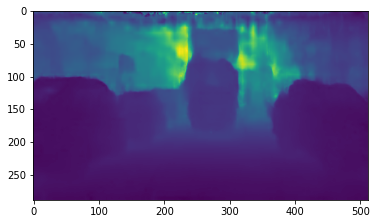

In [36]:
import onnx
import onnxruntime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

''' Load model '''
sess = onnxruntime.InferenceSession("LDRN_KITTI_ResNext101-opt.onnx")

''' Run inference '''
input = preprocess(img_original)
input_name = sess.get_inputs()[0].name
output = sess.run(None, {input_name: input})

''' Show result '''
out = np.array(output[5])
out = np.squeeze(out, 0)
out = np.squeeze(out, 0)
out = out[int(out.shape[0] * 0.18) : , : ]
out = out *　256.0
plt.imshow(out)
plt.show()

In [32]:
out = out / 256.0
np.amax(out), np.amin(out)

(78.70028, 3.8023162)